In [1]:
# download labelme and pyqt
import os # OS allows me to nagivate files and such
import time # time will help with CV
import uuid # allows for custom labels on images
import cv2 # Camera capture
# tensorflow and numpy import
import tensorflow as tf # our main machine learning software
import json
import numpy as np
from matplotlib import pyplot as plt

2023-06-06 09:03:44.651320: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMAGES_PATH = os.path.join('Data','Images') # making the path of the images the image folder
images = 100 # taking 100 images

In [3]:
cap = cv2.VideoCapture(0) # using default 0 as 1 was giving problems
for imgnum in range(images): # running through 100 takes
    print('Collecting image {}'.format(imgnum)) # just a print out to help me know when it is done
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame) # stores image to its file name
    cv2.imshow('frame', frame)
    time.sleep(0.5)

KeyboardInterrupt: 

In [ ]:
# limit the gpu memory growth, if not done tensorflow will allocate all data to gpus, overloading them
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True) # change configs of each gpu being used

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
### BEGIN TENSORFLOW PIPELINE ###

ImageDataSet = tf.data.Dataset.list_files('Data/Images/*.jpg')
ImageDataSet.as_numpy_iterator().next() # Allows us to use items in the dataset

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: Data/Images/*.jpg'

In [ ]:
def LoadImage(x): #Loads the image and takes byte information then decoades
    ByteInformation = tf.io.read_file(x) # tensorflow code to load image and grab byte information
    img = tf.io.decode_jpeg(ByteInformation) # loading image into form that tensorflow can work with
    return img

In [ ]:
ImageDataSet = ImageDataSet.map(LoadImage) # mapping all of the images through the function
# Map is a super helpful function as it allows all of the images to be handled at once

In [ ]:
ImageDataSet.as_numpy_iterator().next() # iterate through the images to see what they are / how they look (numpy array)

array([[[111, 119,  82],
        [112, 120,  81],
        [112, 118,  80],
        ...,
        [147, 140, 114],
        [146, 139, 113],
        [146, 139, 113]],

       [[111, 119,  82],
        [111, 119,  82],
        [112, 118,  80],
        ...,
        [147, 140, 114],
        [146, 139, 113],
        [146, 139, 113]],

       [[111, 118,  84],
        [111, 119,  82],
        [111, 119,  80],
        ...,
        [147, 140, 114],
        [147, 140, 114],
        [147, 140, 114]],

       ...,

       [[158, 157, 139],
        [158, 157, 139],
        [158, 157, 139],
        ...,
        [197, 216, 222],
        [196, 215, 219],
        [196, 215, 219]],

       [[157, 156, 138],
        [157, 156, 138],
        [158, 157, 139],
        ...,
        [201, 222, 227],
        [201, 222, 225],
        [200, 221, 224]],

       [[158, 157, 139],
        [158, 157, 139],
        [157, 156, 138],
        ...,
        [206, 227, 232],
        [205, 226, 229],
        [205, 226, 229]]

In [ ]:
### CODE TO DISPLAY IMAGES ###
plot_images = ImageDataSet.batch(4).as_numpy_iterator().next() # takes the next iteration of data that shows up
# taking a batch of 4 images to display to the screen


2023-06-01 14:37:55.411023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-06-01 14:37:55.411482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


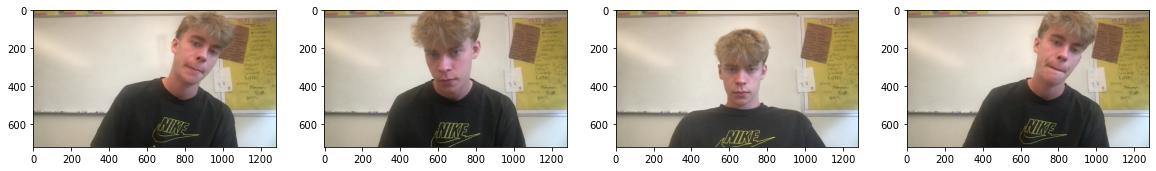

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) # 4 images that are 20x20
for x, image in enumerate(plot_images): 
    ax[x].imshow(image) # displaying image to the screen
plt.show() # plt show to get rid of the mark

In [ ]:
### CREATE TRAIN TEST FOLDERS ###
# 70 / 30 split (15 to test and val)
# Done manually....

# Loop for moving labels to assigned image folders
for folder in ['Train','Test','Val']: # loop through folders
    for file in os.listdir(os.path.join('Data', folder, 'Images')): # make a path from Data to (Train, Test, Val) to Images
        
        filename = file.split()[0]+'.json' # image names are messed up so I had to run this twice - This is grabbing the file name
        existing_filepath = os.path.join('Data','Label', filename) # find the file name in the labels folder
        if os.path.exists(existing_filepath): # if the filename exists
            new_filepath = os.path.join('Data',folder,'Label',filename) 
            os.replace(existing_filepath, new_filepath) # replace the file



In [ ]:
import albumentations as alb
# This package allows me to edit photos quickly, and will boost the preformance of my neural network

In [ ]:
img = cv2.imread(os.path.join('Data','Train', 'Images','0919d0c0-ff03-11ed-ba4b-367dda6fd2d4.jpg')) # this is the code to read in an image
img.shape # wanted to see what the image is captured in (matters later on)

(720, 1280, 3)

In [ ]:
### pipeline for augmenting data ###
AugmentationPipline = alb.Compose([alb.RandomCrop(width=450, height=450), # 450 x 450
                         alb.HorizontalFlip(p=0.5), # assigned variables by Albumentations
                         alb.RandomBrightnessContrast(p=0.2), # assigned variables by Albumentations
                         alb.RandomGamma(p=0.2), # change gamma
                         alb.RGBShift(p=0.2), # change coldor
                         alb.VerticalFlip(p=0.5)], # flip the image
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels'])) # beginning of normalization

In [ ]:
for partition in ['Train','Test','Val']: # finding the partitions in Train Test Split
    counter = 0 # just displaying counter to make sure it is working
    for image in os.listdir(os.path.join('Data', partition, 'Images')): # looping through the images in the (Train, Test, Val) folders
        img = cv2.imread(os.path.join('Data', partition, 'Images', image)) # reading the image in the folder
        counter +=1
        print(counter)
        label_path = os.path.join('Data', partition, 'Label', f'{image.split(".")[0]}.json') # finding the corresponding label path
        if os.path.exists(label_path): # there is a chance that it doesn't exist, I found that 1 in every folder did not exist
            with open(label_path, 'r') as f:
                label = json.load(f)
            coords = [0,0,0,0] # setting coords
            coords[0] = label['shapes'][0]['points'][0][0] # top coord
            coords[1] = label['shapes'][0]['points'][0][1] # top right
            coords[2] = label['shapes'][0]['points'][1][0] # bottom left
            coords[3] = label['shapes'][0]['points'][1][1] # bottom right
            coords = list(np.divide(coords, [1280,720,1280,720])) # normalize using the data from my computer image capture

        try: 
            for x in range(50): # create more data 
                augmented = AugmentationPipline(image=img, bboxes=[coords], class_labels=['face']) # create augmented photo
                cv2.imwrite(os.path.join('AugData', partition, 'Images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image']) # write augmented photo to AugData

                annotation = {} # finding the annotation
                annotation['image'] = image

                if len(augmented['bboxes']) == 0: # this is seeing if there is no bounding box
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 
                else: # if there is, assing the bounding box to the assigned image
                    annotation['bbox'] = augmented['bboxes'][0]
                    annotation['class'] = 1 # class 1 means not 0 I believe


                with open(os.path.join('AugData', partition, 'Label', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f) # write the annotation to the folder

        except Exception as e:
            print(e) # this prevents a crash

1
2
3
4
5
6
7
8
9
10
11
12
13
image must be numpy array type
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
1
2
3
image must be numpy array type
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
image must be numpy array type
5
6
7
8
9
10
11
12
13
14
15
16


In [ ]:
TrainI = tf.data.Dataset.list_files('AugData/Train/Images/*.jpg', shuffle=False) 
TrainI = TrainI.map(LoadImage) # loading all images
TrainI = TrainI.map(lambda x: tf.image.resize(x, (120,120))) # image compression built into tensorflow, (needed for the layers we are using)
TrainI = TrainI.map(lambda x: x/255) # normilize

TestI = tf.data.Dataset.list_files('AugData/Test/Images/*.jpg', shuffle=False)
TestI = TestI.map(LoadImage)
TestI = TestI.map(lambda x: tf.image.resize(x, (120,120)))
TestI = TestI.map(lambda x: x/255)

ValI = tf.data.Dataset.list_files('AugData/Val/Images/*.jpg', shuffle=False)
ValI = ValI.map(LoadImage)
ValI = ValI.map(lambda x: tf.image.resize(x, (120,120)))
ValI = ValI.map(lambda x: x/255)

In [ ]:
def load_labels(x):
    with open(x.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox'] # looks for and returns bounding box and class

In [ ]:
# load .json files (thank you stack overflow)
TrainL = tf.data.Dataset.list_files('AugData/Train/Label/*.json', shuffle=False)
TrainL = TrainL.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16])) 
TestL = tf.data.Dataset.list_files('AugData/Test/Label/*.json', shuffle=False)
TestL = TestL.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
ValL = tf.data.Dataset.list_files('Augdata/Val/Label/*.json', shuffle=False)
ValL = ValL.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
# zip the image and label together so that they are one object
train = tf.data.Dataset.zip((TrainI, TrainL)) # zipping the image and annotation together using .zip
train = train.shuffle(4000) # shuffle
train = train.batch(8) # batchsize of 8
train = train.prefetch(4) # this is standard practice so that as other images are being processed the new batch can be ready

test = tf.data.Dataset.zip((TestI, TestL))
test = test.shuffle(1000)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((ValI, ValL))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


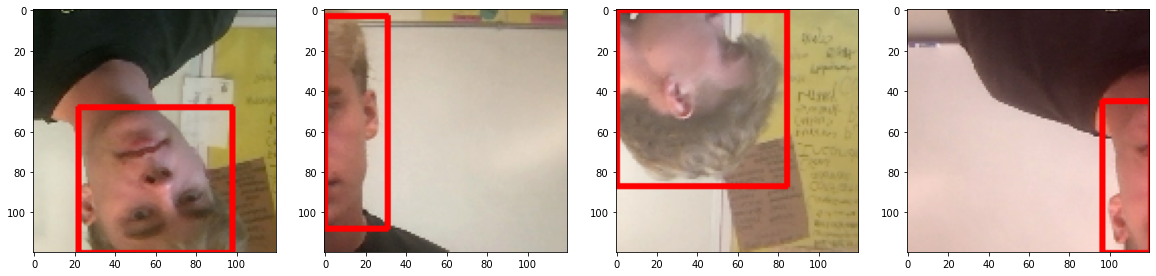

In [ ]:
data_samples = train.as_numpy_iterator() # code to be able to see annotation and random brightness
res = data_samples.next() # grabbing next
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) # setting fig size and images
for x in range(4): # going through 4 times
    sample_image = res[0][x] # grabbing image
    sample_coords = res[1][1][x] # grabbing coords of box
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2) # CV2 allows a rectange to be displayed on an image

    ax[x].imshow(sample_image) # show the atual image

In [2]:
# There is both classification in determining what the face is in each photo and regression when finding out where the box goes
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D # the layers we are using for our model
from tensorflow.keras.applications import VGG16

In [ ]:
vgg = VGG16(include_top = False) # importing Vgg into the system

58889256/58889256 [==============================] - 5s 0us/step


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001) # the optimizer we are going to use

In [ ]:
# vgg is a trained an tested model for image classifcation
def model(): 
    input_layer = Input(shape=(120,120,3)) # this is the beginning image
    
    vgg = VGG16(include_top=False)(input_layer) # don't want the top part of the architecture where the final steps are done

    # This problem is both a classification and regression problem so there must be a model for both items in the training

    # Classification
    f1 = GlobalMaxPooling2D()(vgg) # using maxpool to find the most important parts of the image
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box
    f2 = GlobalMaxPooling2D()(vgg) # using maxpool to find the most important parts of the image
    regress1 = Dense(2048, activation='relu')(f2) # output shape is 2048
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [ ]:
facetracker = model() # init the model

In [ ]:
### Optimization ###
# I don't know how to do this so this is some code I found...
batches_per_epoch = len(train)
lr_decay = (1/0.75 -1)/batches_per_epoch # .33 / 438 batches after they are zipped, batched, and shuffled




In [ ]:
def localization_loss(y_true, yhat): # distance between the coordinate predicted and coordinate that is in the actual photo          
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2])) # square root and find sum (aka distance)
                  
    h_true = y_true[:,3] - y_true[:,1] # actual distance
    w_true = y_true[:,2] - y_true[:,0] # actual distance

    h_pred = yhat[:,3] - yhat[:,1] # what we think is the distance
    w_pred = yhat[:,2] - yhat[:,0] # what we think is the distance
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred)) #distance formula to find delta size
    
    return delta_coord + delta_size # add to find error

In [ ]:
# Define loss functions
classloss = tf.keras.losses.BinaryCrossentropy() # Already built function in keras
regressloss = localization_loss # this is the loss function we built

In [ ]:
### CREATE FACETRACKER CLASS ###
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): # passing through pre-built neural network
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs): # passing through the loss and optimizer
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch # unpacking into the target and prediction
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True) # giving our x value to our initial model to get class and coordinate
            
            batch_classloss = self.closs(y[0], classes) # passing through loss functions
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords) # passing through loss functions
            
            total_loss = batch_localizationloss+0.5*batch_classloss # total loss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): # same but no back prop
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)


In [ ]:
model = FaceTracker(facetracker) # this is the model I am using, the main class Facetracker which controls what is being trained as well as the loss function, 
# and the facetracker model which is using the vgg16 architecture

In [ ]:
model.compile(opt, classloss, regressloss)

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
438/438 [==============================] - ETA: 0s - total_loss: 0.6191 - class_loss: 0.1575 - regress_loss: 0.5404

2023-06-04 18:30:42.594814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [750]
	 [[{{node Placeholder/_5}}]]
2023-06-04 18:30:42.595245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [750]
	 [[{{node Placeholder/_5}}]]


438/438 [==============================] - 640s 1s/step - total_loss: 0.6178 - class_loss: 0.1571 - regress_loss: 0.5392 - val_total_loss: 1.1922 - val_class_loss: 0.2652 - val_regress_loss: 1.0596
Epoch 2/10
438/438 [==============================] - 626s 1s/step - total_loss: 0.4213 - class_loss: 0.1207 - regress_loss: 0.3610 - val_total_loss: 1.8200 - val_class_loss: 2.0103 - val_regress_loss: 0.8149
Epoch 3/10
438/438 [==============================] - 702s 2s/step - total_loss: 0.3395 - class_loss: 0.1011 - regress_loss: 0.2890 - val_total_loss: 0.0992 - val_class_loss: 1.0524e-04 - val_regress_loss: 0.0992
Epoch 4/10
438/438 [==============================] - 1107s 3s/step - total_loss: 0.3488 - class_loss: 0.1015 - regress_loss: 0.2980 - val_total_loss: 0.1682 - val_class_loss: 0.1326 - val_regress_loss: 0.1019
Epoch 5/10
438/438 [==============================] - 865s 2s/step - total_loss: 0.2831 - class_loss: 0.0871 - regress_loss: 0.2396 - val_total_loss: 0.0660 - val_class_l

In [3]:
from tensorflow.keras.models import load_model

In [ ]:
# facetracker.save('facetracker_v1')

INFO:tensorflow:Assets written to: facetracker_v1/assets


INFO:tensorflow:Assets written to: facetracker_v1/assets


In [4]:
facetracker = load_model('facetracker_v1')

In [5]:
cap = cv2.VideoCapture(0) # using video cap 0 agai
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[135:585, 415:865,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 139ms/step


KeyboardInterrupt: 